In [1]:
# import libraries
import os
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


# code copied from 
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

Using TensorFlow backend.


[Code Source](https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)

# Intro

The goal pf this project is to build a stell defect detector. This [kaggle](https://www.kaggle.com/c/severstal-steel-defect-detection/notebooks?sortBy=hotness&group=everyone&pageSize=20&competitionId=14241&language=Python&outputType=Visualization) dataset provides images with four types of defects. To build an algorithm capable of identifying and count the type of defects in an image is a two steps process. The firt step is to classify if the image has a defect or not. If the image has a defect the second step is to identify the type fo defects and count them. In this notebook we will build a binary image classifier to determine if steel has a defect.

According to the EDA done by this [person](https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda) the train csv file only contains the images that have defects and each class label represents the type of defect. In other words, one single image can have more than one class label. To solve this problem the proper approach would be to first detect if there is a defect. To separat the images that have defects and those that do not I will create two directories one for each.


# Feature Engineering

In [9]:
base_dir = '/Users/carlostavarez/Desktop/severstal-steel-defect-detection'

In [10]:
images_tr_dir = base_dir + '/train_images'

In [11]:
df = pd.read_csv(base_dir + '/train.csv')

In [12]:
df.shape

(7095, 3)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
ImageId          7095 non-null object
ClassId          7095 non-null int64
EncodedPixels    7095 non-null object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [14]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [15]:
df.tail()

,ImageId,ClassId,EncodedPixels
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...
7094,ffffd67df.jpg,3,30931 43 31103 127 31275 211 31489 253 31745 2...


In [29]:
imgs_defect_set = set(df['ImageId'].unique())

In [30]:
ims_dir_set = set(os.listdir(images_tr_dir))

In [31]:
imgs_noDefect_set = ims_dir_set.difference(imgs_defect_set)

In [37]:
no_defects_df = pd.DataFrame(imgs_noDefect_set, columns=['imagesID'])

In [40]:
# no_defects_df.head()

In [41]:
no_defects_df['label'] = 0

In [42]:
defects_df = pd.DataFrame(imgs_defect_set, columns=['imagesID'])
defects_df['label'] = 1

In [43]:
no_defects_df.head()

,imagesID,label
0,26bcc93ff.jpg,0
1,1d7fb0fa8.jpg,0
2,94dac8944.jpg,0
3,b18d448a7.jpg,0
4,08ba29346.jpg,0


In [44]:
defects_df.head()

,imagesID,label
0,f2f5ab55c.jpg,1
1,78d2258f2.jpg,1
2,4340e1e42.jpg,1
3,0d22c1559.jpg,1
4,ac7e898e6.jpg,1


In [51]:
no_defects_df.shape, defects_df.shape

((5902, 2), (6666, 2))

In [54]:
no_defects_df.shape[0]/len(ims_dir_set), defects_df.shape[0]/len(ims_dir_set)

(0.4696053469127944, 0.5303946530872056)

In [59]:
imgs_df = pd.concat([no_defects_df, defects_df], ignore_index=True)

In [60]:
imgs_df.shape

(12568, 2)

In [62]:
imgs_df.to_csv('train_binary.csv', index=False)

In [18]:
new_dir = '/Users/carlostavarez/Desktop/imgs_bin'

In [19]:
os.mkdir(new_dir)

In [67]:
train_dir = new_dir +'/train'
valid_dir = new_dir + '/valid'
test_dir = new_dir +'/test'


os.mkdir(train_dir)
os.mkdir(valid_dir)
os.mkdir(test_dir)

In [68]:
# train
os.mkdir(train_dir + '/0')
os.mkdir(train_dir + '/1')

# val
os.mkdir(valid_dir + '/0')
os.mkdir(valid_dir + '/1')


# test
os.mkdir(test_dir + '/0')
os.mkdir(test_dir + '/1')


In [69]:
train_dir

'/Users/carlostavarez/Desktop/imgs_bin/train'

In [70]:
valid_dir

'/Users/carlostavarez/Desktop/imgs_bin/valid'

In [71]:
test_dir

'/Users/carlostavarez/Desktop/imgs_bin/test'

In [72]:
imgs_df.head(2)

,imagesID,label
0,26bcc93ff.jpg,0
1,1d7fb0fa8.jpg,0


In [73]:
x = imgs_df['imagesID']
y = imgs_df['label']

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42, train_size=0.9, shuffle=True)

In [75]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.9, shuffle=True)

In [76]:
x_train.shape, x_test.shape, x_val.shape

((10179,), (1257,), (1132,))

In [77]:
images_tr_dir

'/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images'

In [78]:
def move_file(from_dir, to_dir, imgs_list, labels_list):
    
    for img, lbl in zip(imgs_list, labels_list):
        
        dst = to_dir +'/' + str(lbl)
        
        src = os.path.join(from_dir, img)
        dst = os.path.join(dst, img)
        shutil.copyfile(src, dst)
        
    print("{} images were copied from \n{} \nto \n{}".format(len(imgs_list), from_dir, to_dir))

In [79]:
move_file(images_tr_dir, train_dir, x_train, y_train)

10179 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_bin/train


In [80]:
move_file(images_tr_dir, valid_dir, x_val, y_val)

1132 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_bin/valid


In [81]:
move_file(images_tr_dir, test_dir, x_test, y_test)

1257 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_bin/test


# Train Resnet model

In [221]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/Users/carlostavarez/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [222]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [223]:
# # resnet.layers = True

# bolck_bol = False

# for idx in range(len(resnet.layers)):
    
#     if resnet.layers[idx].name == 'res5c_branch2b':
#         bolck_bol = True
        
#     if bolck_bol:
#         resnet.layers[idx].trainable = True
        
#     else:
#         resnet.layers[idx].trainable = False

In [224]:
model = Sequential()

model.add(resnet)
# model.add(Conv2D(4096, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [225]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 1026      
Total params: 49,803,650
Trainable params: 49,750,530
Non-trainable params: 53,120
_________________________________________________________________


In [226]:
datagen = ImageDataGenerator(rescale=1.0/255)
traingen = ImageDataGenerator(
                rotation_range=40, 
                width_shift_range=0.2, 
                height_shift_range=0.2, 
                shear_range=0.2, 
                zoom_range=0.2, 
                horizontal_flip=True)

In [227]:
trn_gen = datagen.flow_from_directory(train_dir, target_size=(150, 150))
tst_gen = datagen.flow_from_directory(test_dir, target_size=(150, 150))
val_gen = datagen.flow_from_directory(valid_dir, target_size=(150, 150))

Found 10179 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 1132 images belonging to 2 classes.


In [228]:
history = model.fit_generator(trn_gen, 
                              steps_per_epoch=20, 
                              validation_data=val_gen, 
                              validation_steps=5, 
                              epochs=10)

Epoch 1/10
20/20 [==============================] - 91s 5s/step - loss: 4.1292 - acc: 0.6805 - val_loss: 819.1237 - val_acc: 0.4313
Epoch 2/10
20/20 [==============================] - 73s 4s/step - loss: 0.5610 - acc: 0.7625 - val_loss: 85.2115 - val_acc: 0.5000
Epoch 3/10
20/20 [==============================] - 74s 4s/step - loss: 0.5255 - acc: 0.7492 - val_loss: 5.0438 - val_acc: 0.5188
Epoch 4/10
20/20 [==============================] - 74s 4s/step - loss: 0.5055 - acc: 0.7547 - val_loss: 0.6905 - val_acc: 0.4812
Epoch 5/10
20/20 [==============================] - 70s 4s/step - loss: 0.4705 - acc: 0.8061 - val_loss: 0.6972 - val_acc: 0.4437
Epoch 6/10
20/20 [==============================] - 74s 4s/step - loss: 0.5541 - acc: 0.7133 - val_loss: 7.5365 - val_acc: 0.4313
Epoch 7/10
20/20 [==============================] - 74s 4s/step - loss: 0.5056 - acc: 0.7570 - val_loss: 0.6928 - val_acc: 0.4938
Epoch 8/10
20/20 [==============================] - 73s 4s/step - loss: 0.5091 - acc: 0

In [231]:
model.evaluate_generator(trn_gen)

[0.6419317126274109, 0.47067493200302124]

In [229]:
model.evaluate_generator(val_gen)

[0.8288087844848633, 0.46024733781814575]

In [230]:
model.evaluate_generator(tst_gen)

[0.640535831451416, 0.4693715274333954]

In [256]:
history.history['acc']

[0.68046874,
 0.7625,
 0.74921876,
 0.7546875,
 0.80605567,
 0.7132813,
 0.75703126,
 0.77421874,
 0.7859375,
 0.7828125]

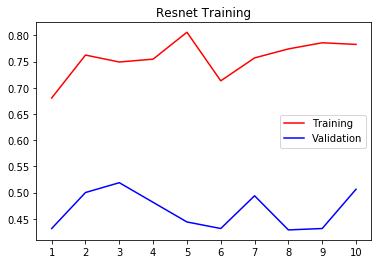

In [274]:
plt.plot(history.history['acc'], c='r', label='Training')
plt.plot(history.history['val_acc'], c='b', label='Validation')
plt.xticks(np.arange(len(history.history['val_acc'])), np.arange(len(history.history['val_acc']))+1)
plt.legend()
plt.savefig(title + '.png')
plt.title(title)
plt.show()

In [281]:
def plot_training(history, title):
    
    plt.plot(history.history['acc'], c='r', label='Training')
    plt.plot(history.history['val_acc'], c='b', label='Validation')
    plt.xticks(np.arange(len(history.history['val_acc'])), np.arange(len(history.history['val_acc']))+1)
    plt.legend()
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

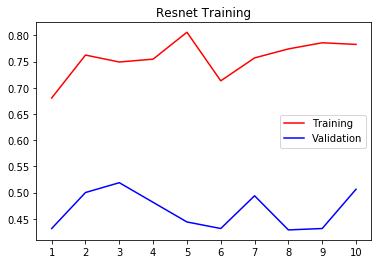

In [282]:
plot_training(history, 'Resnet Training')

In [240]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(2, activation='sigmoid'))



conv_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [241]:
conv_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 18, 18, 256)     

In [242]:
history_conv = conv_model.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 92s 462ms/step - loss: 0.6884 - acc: 0.5363 - val_loss: 0.6784 - val_acc: 0.5424
Epoch 2/10
200/200 [==============================] - 93s 466ms/step - loss: 0.6732 - acc: 0.6062 - val_loss: 0.6766 - val_acc: 0.6861
Epoch 3/10
200/200 [==============================] - 93s 464ms/step - loss: 0.6158 - acc: 0.6825 - val_loss: 0.5967 - val_acc: 0.6750
Epoch 4/10
200/200 [==============================] - 95s 476ms/step - loss: 0.5746 - acc: 0.7048 - val_loss: 0.5260 - val_acc: 0.6915
Epoch 5/10
200/200 [==============================] - 97s 484ms/step - loss: 0.5588 - acc: 0.7175 - val_loss: 0.4999 - val_acc: 0.6864
Epoch 6/10
200/200 [==============================] - 102s 511ms/step - loss: 0.5382 - acc: 0.7254 - val_loss: 0.5713 - val_acc: 0.7058
Epoch 7/10
200/200 [==============================] - 102s 510ms/step - loss: 0.5353 - acc: 0.7409 - val_loss: 0.7173 - val_acc: 0.7269
Epoch 8/10
200/200 [==============================] -

In [243]:
conv_model.evaluate_generator(trn_gen)

[0.30675745010375977, 0.7658414244651794]

In [244]:
conv_model.evaluate_generator(val_gen)

[0.5153838992118835, 0.7469081282615662]

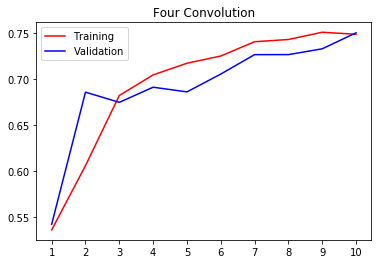

In [283]:
plot_training(history_conv, 'Four Convolution')

In [249]:
conv_model2 = Sequential()

conv_model2.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Flatten())
conv_model2.add(Dense(512, activation='relu'))
conv_model2.add(Dense(2, activation='sigmoid'))



conv_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [250]:
conv_model2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 41472)           

In [251]:
history_conv2 = conv_model2.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 93s 467ms/step - loss: 0.6652 - acc: 0.5948 - val_loss: 0.5847 - val_acc: 0.6984
Epoch 2/10
200/200 [==============================] - 96s 481ms/step - loss: 0.5863 - acc: 0.6904 - val_loss: 0.6162 - val_acc: 0.6991
Epoch 3/10
200/200 [==============================] - 99s 494ms/step - loss: 0.5612 - acc: 0.7122 - val_loss: 0.8167 - val_acc: 0.6593
Epoch 4/10
200/200 [==============================] - 98s 488ms/step - loss: 0.5351 - acc: 0.7318 - val_loss: 0.6181 - val_acc: 0.6785
Epoch 5/10
200/200 [==============================] - 98s 489ms/step - loss: 0.5237 - acc: 0.7371 - val_loss: 0.6132 - val_acc: 0.7152
Epoch 6/10
200/200 [==============================] - 100s 500ms/step - loss: 0.5053 - acc: 0.7467 - val_loss: 0.4213 - val_acc: 0.7288
Epoch 7/10
200/200 [==============================] - 97s 486ms/step - loss: 0.4934 - acc: 0.7559 - val_loss: 0.5111 - val_acc: 0.7453
Epoch 8/10
200/200 [==============================] - 

In [252]:
conv_model2.evaluate_generator(trn_gen)

[0.1994859129190445, 0.7801355719566345]

In [253]:
conv_model2.evaluate_generator(val_gen)

[0.5000433921813965, 0.7636925578117371]

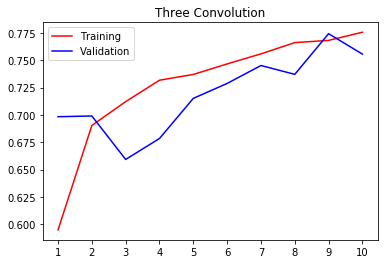

In [284]:
plot_training(history_conv2, 'Three Convolution')

In [88]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [36]:
# train_gen = datagen.flow(x_trn, y_trn, batch_size=20)
# valid_gen = datagen.flow(x_val, y_val, batch_size=20)

s_datagen = ImageDataGenerator(rescale=1.0/255, 
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True)

bgen = BalancedDataGenerator(x_trn, y_trn, s_datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [37]:
# bgen_vl = datagen.flow(x_val, y_val, batch_size=32)
# steps_val = bgen_vl.steps_per_epoch

In [38]:
valid_gen = datagen.flow(x_val, y_val, batch_size=32)

In [39]:
steps_per_epoch, steps_val

(579, 64)

In [48]:
history = model.fit_generator(bgen, 
                              steps_per_epoch=steps_per_epoch, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//32, 
                              epochs=10)

Epoch 1/10
579/579 [==============================] - 3569s 6s/step - loss: 0.7329 - acc: 0.7209 - val_loss: 1.0879 - val_acc: 0.6974
Epoch 2/10
579/579 [==============================] - 3551s 6s/step - loss: 0.5215 - acc: 0.8031 - val_loss: 2.2688 - val_acc: 0.1298
Epoch 3/10
579/579 [==============================] - 3627s 6s/step - loss: 0.4656 - acc: 0.8258 - val_loss: 2.5201 - val_acc: 0.1239
Epoch 4/10
579/579 [==============================] - 3881s 7s/step - loss: 0.4254 - acc: 0.8437 - val_loss: 2.1979 - val_acc: 0.0369
Epoch 5/10
579/579 [==============================] - 3731s 6s/step - loss: 0.4047 - acc: 0.8522 - val_loss: 2.0635 - val_acc: 0.0339
Epoch 6/10
579/579 [==============================] - 3626s 6s/step - loss: 0.3921 - acc: 0.8556 - val_loss: 1.9155 - val_acc: 0.0310
Epoch 7/10
579/579 [==============================] - 3642s 6s/step - loss: 0.3725 - acc: 0.8631 - val_loss: 2.1238 - val_acc: 0.0428
Epoch 8/10
579/579 [==============================] - 3636s 6s

In [49]:
model.evaluate_generator(bgen)

[2.2005739212036133, 0.25015702843666077]

In [50]:
model.evaluate_generator(valid_gen)

[3.1303462982177734, 0.035211268812417984]

In [32]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
y_trn_pred = model.predict(x_trn)

In [34]:
y_val_pred = model.predict(x_val)

In [35]:
y_trn_pred

array([[4.4343080e-03, 1.4488957e-03, 9.8969406e-01, 4.4227676e-03],
       [1.7619923e-06, 1.0551557e-07, 9.9999809e-01, 1.4338494e-08],
       [2.9367459e-04, 5.9036534e-05, 9.9931002e-01, 3.3724587e-04],
       ...,
       [5.7238364e-04, 1.6210042e-04, 9.9840242e-01, 8.6316268e-04],
       [8.1247366e-05, 1.8141752e-04, 9.9636590e-01, 3.3714673e-03],
       [1.9814749e-04, 2.8437789e-05, 9.9947459e-01, 2.9880885e-04]],
      dtype=float32)

In [43]:
p = list(y_trn_pred[0])

In [47]:
p_mx = max(p)

In [48]:
p.index(p_mx)

2

In [49]:
def convert_class(y):
    
    lb_list = []
    
    for i in y:
        
        i = list(i)
        
        i_mx = max(i)
        
        i_id = i.index(i_mx)
        
        lb_list.append(i_id)
        
    return np.array(lb_list)

In [51]:
y_tr_lb = convert_class(y_trn)

In [52]:
y_tr_lb_pred = convert_class(y_trn_pred)

In [53]:
y_vl_lb = convert_class(y_val)
y_vl_lb_pred = convert_class(y_val_pred)

In [57]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [65]:
# training

confusion_matrix(y_tr_lb, y_tr_lb_pred)

array([[ 132,    4,  671,    0],
       [   2,   16,  204,    0],
       [   6,    0, 4629,    0],
       [   0,    0,  721,    0]])

In [67]:
print(classification_report(y_tr_lb, y_tr_lb_pred))

              precision    recall  f1-score   support

           0       0.94      0.16      0.28       807
           1       0.80      0.07      0.13       222
           2       0.74      1.00      0.85      4635
           3       0.00      0.00      0.00       721

    accuracy                           0.75      6385
   macro avg       0.62      0.31      0.32      6385
weighted avg       0.69      0.75      0.66      6385



In [71]:
accuracy_score(y_tr_lb, y_tr_lb_pred)

0.748159749412686

In [68]:
# validation

confusion_matrix(y_vl_lb, y_vl_lb_pred)

array([[ 16,   1,  73,   0],
       [  0,   4,  21,   0],
       [  0,   0, 515,   0],
       [  0,   0,  80,   0]])

In [69]:
print(classification_report(y_vl_lb, y_vl_lb_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.30        90
           1       0.80      0.16      0.27        25
           2       0.75      1.00      0.86       515
           3       0.00      0.00      0.00        80

    accuracy                           0.75       710
   macro avg       0.64      0.33      0.36       710
weighted avg       0.70      0.75      0.67       710



In [72]:
accuracy_score(y_vl_lb, y_vl_lb_pred)

0.7535211267605634

## Second model

In [73]:
model = Sequential()

model.add(resnet)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [74]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=len(x_trn)//20, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//20, 
                              epochs=10)

Epoch 1/10
319/319 [==============================] - 546s 2s/step - loss: 0.5471 - acc: 0.7884 - val_loss: 1.1094 - val_acc: 0.7214
Epoch 2/10
319/319 [==============================] - 466s 1s/step - loss: 0.2994 - acc: 0.8742 - val_loss: 0.8498 - val_acc: 0.7304
Epoch 3/10
179/319 [===============>..............] - ETA: 2:59 - loss: 0.2055 - acc: 0.9128

KeyboardInterrupt: 